<a href="https://colab.research.google.com/github/RobertoAlessandri/STSA/blob/main/STSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
###----------Imports----------###

import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy as sp
import pandas as pd
import soundfile as sf
from scipy.io import wavfile
from IPython.core.pylabtools import select_figure_formats
import librosa.display 

## Definitions

In [2]:
###----------Defs----------###

def print_plot_play(x, Fs, hopsize, text=''):
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(10, 2)) # (6, 1.5)
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))

    X = librosa.stft(x, hop_length = hopsize)
    plt.figure(figsize=(12, 7))
    librosa.display.specshow(librosa.power_to_db(X**2), x_axis = 'time', y_axis='log', cmap='viridis');
    plt.clim(-40, None);
    plt.colorbar();
    plt.title('Signal Spectrogram');

In [3]:
def noiseFrameEstiamtor(Fs, sig, winlen, hopsize):
  only_noise_samples = int(Fs/2)
  hopsize_noise = int(only_noise_samples)
  L = len(sig)
  n_frames_noise = int(np.floor((L-only_noise_samples)/hopsize_noise) + 1) # number of
                                                                           # time 
                                                                           # frames

  # These vectors are used for a later representation of the signal
  #zcr_vector = np.zeros([n_frames_noise])
  #ste_vector = np.zeros([n_frames_noise])
  zcr_vector = []
  ste_vector = []

  # We use as starting values for the later searche of the optimimum ones, the 
  # average zcr (Zero-Crossing Rate)  and ste (Short-Time Energy) of the whole 
  # audio signal
  #zcr_whole = (1/(L-1))*np.sum(np.abs(np.diff(np.sign(sig))));
  zcr_whole = np.mean(librosa.feature.zero_crossing_rate(sig, frame_length = winlen, hop_length = hopsize))
  ste_whole = np.sum(sig**2) / L
  zcr = zcr_whole
  #print('zcr_whole = ', zcr_whole)
  ste = ste_whole
  #print('ste_whole = ', ste_whole)
  noise_frame = 0 # we are going to save the frame in order better understand
                # if the algorithm pointed out a reasonable frame

  for nn in range (0, n_frames_noise-1):
    # Segment the corrupted signal
    x_n = np.asarray(sig[nn*hopsize_noise+1 : nn*hopsize_noise + only_noise_samples])

    if nn == 0:
      x_noise = nn

    #zcr_frame = (1/(only_noise_samples-1))*np.sum(np.abs(np.diff(np.sign(x_n))))
    zcr_frame = np.mean(librosa.feature.zero_crossing_rate(x_n))
  #print('zcr frame = ', zcr_frame)
    ste_frame = sum(x_n**2)/only_noise_samples
  #print('ste frame = ', ste_frame)
    zcr_vector.append(zcr_frame)
    ste_vector.append(ste_frame)
    # We assume that the noisiest part of an audio signal is the one with the 
    # lowest ste and highest zcr
    if (zcr_frame > zcr and ste_frame < ste):
      noise_frame = nn
      zcr = zcr_frame
      ste = ste_frame
      #print('x noise = ', x_noise)
      x_noise = x_n

  # Vector normalization just for visualization
  zcr_vector_n = zcr_vector / np.max(zcr_vector);
  ste_vector_n = ste_vector / np.max(ste_vector);
  t_nn = np.arange(0, n_frames_noise - 1)

  plt.figure(figsize=(16,5))
  # summarize history for accuracy
  plt.plot(zcr_vector_n)
  plt.plot(ste_vector_n)
  plt.title('Noise Estimate')
  plt.ylabel('zcr-ste')
  plt.xlabel('frames [s/2]')
  plt.legend(['zcr', 'ste'], loc='upper left')

  print('Noisiest frame is the number = {}'.format(noise_frame))

  r_v = np.correlate(x_noise, x_noise, 'full')
  P_v = np.abs(np.fft.fft(r_v, nfft))
  mean_noise = np.mean(sig[noise_frame*hopsize_noise + 1 : noise_frame*hopsize_noise + only_noise_samples]);

  f, Pxx_den = sp.signal.periodogram(x_noise, fs=1.0, window=win, nfft=nfft, detrend='constant', return_onesided=True, scaling='density', axis=- 1)
  PSD_Noise_Estimate = Pxx_den


  plt.figure(figsize=(16,5))
  plt.semilogy(f * Fs, PSD_Noise_Estimate)
  plt.ylim([1e-7, 1e2])
  plt.xlabel('frequency [Hz]')
  plt.ylabel('PSD [V**2/Hz]')
  plt.title('Noise Power Spectral Density Estimate')
  plt.show()

  return x_noise, noise_frame, n_frames_noise, hopsize_noise, only_noise_samples, mean_noise, r_v, P_v

In [4]:
def suppressionRule(n_frames, n_frames_noise, precision, a, b, c, hopsize, winlen, win, nfft, P_v):
  frames_ratio = n_frames / n_frames_noise # will be explained later

  ## Rule

  out = []
  out = np.zeros(L)

  for n in range (0, n_frames-1):
    # Segment the corrupted signal
    x_n = sig[n*hopsize: n*hopsize + winlen]
    x_n_w = win * x_n # Windowing
    X_n = np.fft.fft(x_n_w, nfft) # FFT
    P_X = np.abs(X_n)**2
    #P_X_min = np.min(P_X(P_X>0)) / 10
    for i in range(0, len(P_X)):
      if P_X[i] == 0:
        P_X[i] = precision # avoids numerical issues when P_X == 0
    N = len(X_n)

    # Gain Estimation
    Z_B = P_X - a * (P_v**c)
    for i in range(0, len(Z_B)):
      if Z_B[i] < 0:
        Z_B[i] = 0 # This should be considered as the Power Spectrum of the 
                 # "clean" signal. So as Power Spectrum, it can't have negative
                 # values (which may appear due to random fluctuations)
    Z = Z_B/P_X
    G = Z**b

    # Apply the attenuation to the frame spectrum
    S = X_n * G

    # Compute the inverse FFT of the filtered frame. This corresponds to an 
    # estimate of the clean speech
    s_n = np.fft.ifft(S, nfft)


    # Window the filtered time-domain frame
    s_n_w = win*s_n

    # OverLap-and-Add (OLA)
    out[n*hopsize  : n*hopsize + winlen] = out[n*hopsize  : n*hopsize + winlen] + s_n_w;

    # Save the filter to visualize how it attenuates what should be the noisiest 
    # frame
    if (n == np.floor(noise_frame*frames_ratio)):
      clean_frame = n
      G_n = G

      f_G = Fs*np.arange(len(G_n))/nfft

      plt.figure(figsize=(12, 7))
      plt.plot(f_G, G_n)
      plt.xlabel('Frequency [Hz]')
      plt.ylabel('Gain')
      plt.title('Most suppressed frames filter');

  return out

In [5]:
def printAndPlotResults(out, sig, nfft, noise_frame, hopsize_noise, only_noise_samples, r_v, precision, mean_sig, mean_noise, hopsize):
  MSE = np.sum((out - sig )**2)/len((out-sig)**2)
  var_out = np.var(out)
  var_in = np.var(sig)

  # Power Spectrum of original and cleaned audio signal
  P_S_total = np.abs(np.fft.fft(out, nfft))**2
  P_X_total = np.abs(np.fft.fft(sig, nfft))**2

  # Power Spectrum Noise Estimate for clean signal
  v_clean = out[noise_frame*hopsize_noise + 1 : noise_frame*hopsize_noise + only_noise_samples];
  r_v_clean = np.correlate(v_clean, v_clean, 'full');
  P_v_new = np.abs(np.fft.fft(r_v, nfft))**2 + precision;
  P_v_clean_new = np.abs(np.fft.fft(r_v_clean, nfft))**2 + precision;

  # Singal-to-Noise Ratio (SNR) before and after attenuation
  SNR_in = librosa.power_to_db(np.mean((P_X_total/P_v_new)))
  SNR_out = librosa.power_to_db(np.mean((P_S_total/P_v_clean_new)))
  print('SNR in = {}'.format(SNR_in))
  print('SNR out = {}'.format(SNR_out))

  out = out + mean_sig - mean_noise

  print_plot_play(x=out, Fs=Fs, hopsize = hopsize, text='WAV file: ')


## Loading files

In [6]:
from IPython.core.pylabtools import select_figure_formats
###----------Reads----------###
Fs = 44100;

# Read/Load wav
fn_wav = os.path.join('source_SuzanneVega_vocal.wav')
sig_m, Fs = librosa.load(fn_wav, sr=Fs)

# Remove the mean to be sure to have a zero-mean signal
mean_sig = np.mean(sig_m)
sig = sig_m - mean_sig
L = len(sig) # Signal length
pow2 = np.floor(np.log2(L))
L_nfft = 2**pow2


## Short-Time Processing Params

Considering Fs = 44100

### Reasons to increase window size:
* The level of signal components that are mistakenly cancelled by the restoration process increases with the bandwidth of the analyzing window (this would suggest at least 40 ms -> 1764 samples)

### Reasons to reduce window size:
* The signal corresponds on fundamental tone plus partials. And these compontents can be considered fixed during short analysis windows (this would suggest 20 ms -> 882 samples)
* To avoid remaining noise to be correlated to the processed signal is better to have short frames in which is sure that there are only noise components (this would suggest 20-30 ms -> 882-1323 samples)
* Transient signals will lead to distortions

### Reasons to reduce hop-size
* Is important to avoid sub-band spectral aliasing, which could create distortions (overlap from 50-to-75 %)

A suitable value of the sub-frame which encompasses a large enough window of data while not seriously violating the assumption of short-term fixed frequency components is N = 1024 or 2048.


In [7]:
## Short-time processing params
winlen = 2048 # Length of the analysis window
win = np.hanning(winlen)
hopsize = int(winlen/4) 
numHopsPerFrame = winlen/hopsize
n_frames = int(np.floor((L-winlen)/hopsize) +1)
nfft = winlen # Number of FFT frequency bins# 

WAV file:  Fs = 44100, x.shape = (486935,), x.dtype = float32


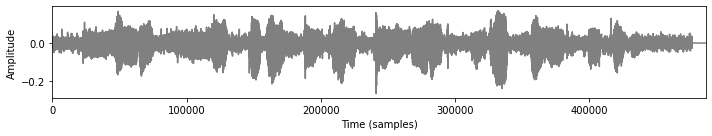

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


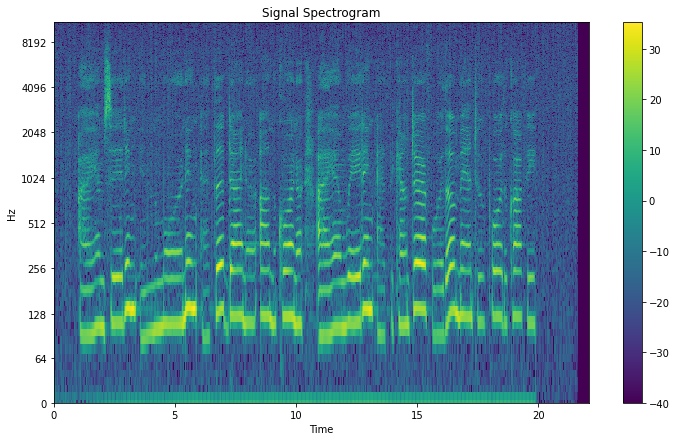

In [8]:
print_plot_play(x=sig_m, Fs=Fs, hopsize = hopsize, text='WAV file: ')

## Noise Estimation

We search for the more suited half-second frame to use for the noise
estimatation.
We search inside the audio signal for the frame with the best combination of zero-crossing rate (high) and short-time energy.

Noisiest frame is the number = 10


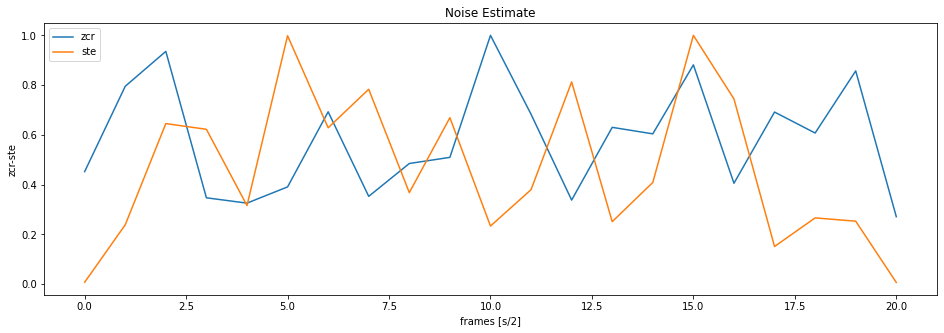

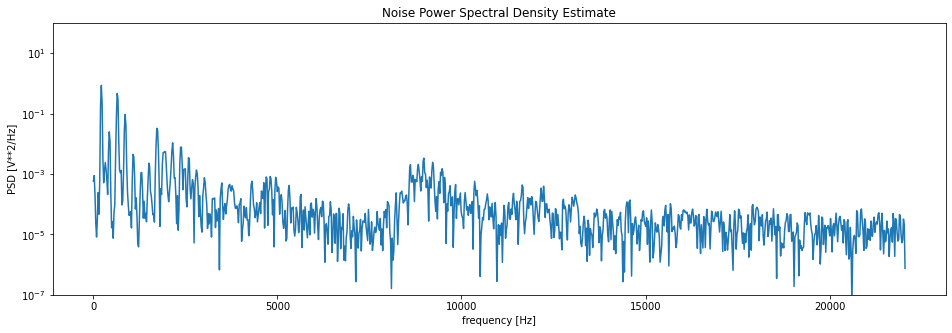

In [9]:
x_noise, noise_frame, n_frames_noise, hopsize_noise, only_noise_samples, mean_noise, r_v, P_v  = noiseFrameEstiamtor(Fs, sig, winlen, hopsize)

## Suppression Rule

Configurations:
- Wiener Filter: a = b = c = 1
- Power Spectral Matching: a = c = 1, b = 1/2
- Spectral Matching: a = b = 1, c = 1/2
- Spectral Matching, leaving noise floor to reduce Musical Noise: a = c = 1/2, b = 1
- Wiener Filter, sovra-estimating noise, to reduce Musical Noise: a = 9/2, b = c = 1

WIENER FILTER CASE



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


POWER SPECTRAL MATCHING CASE



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


SPECTRAL MATCHING CASE



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


SPECTRAL MATCHING WITH NOISE FLOOR CASE



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


WIENER FILTER WITH NOISE SOVRAESTIMATION CASE



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


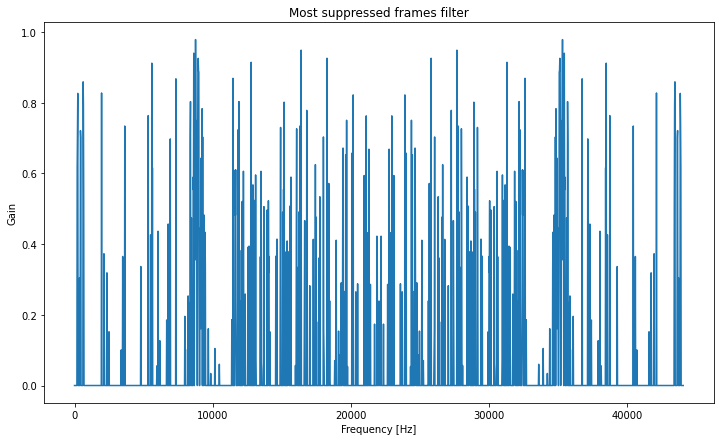

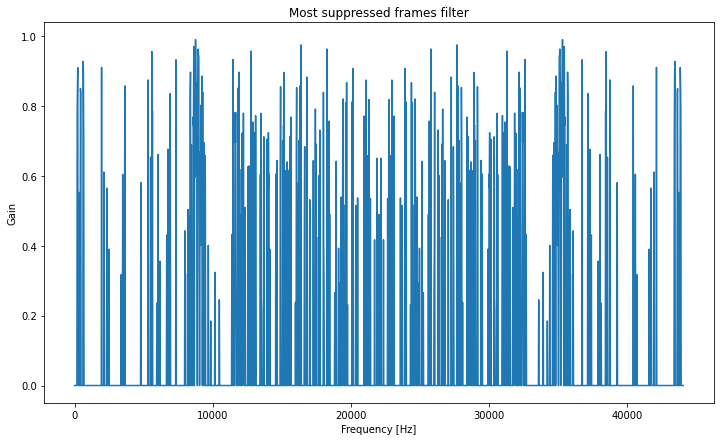

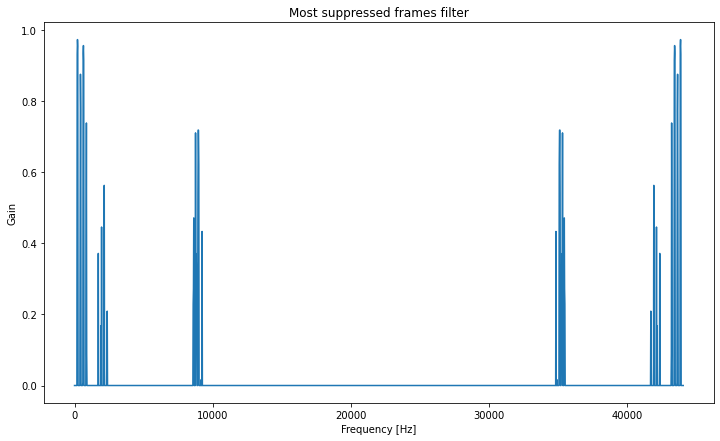

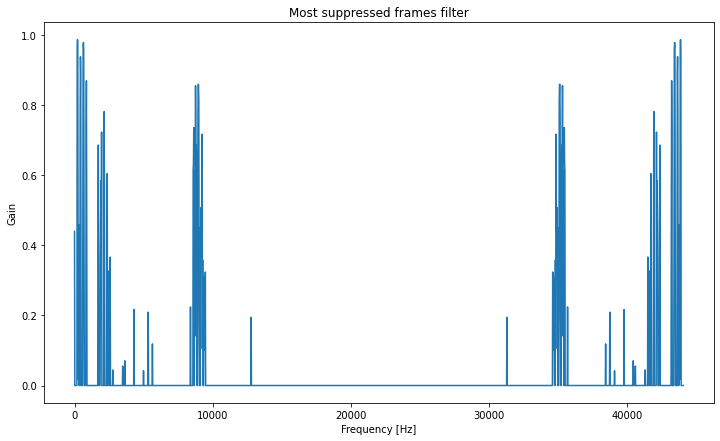

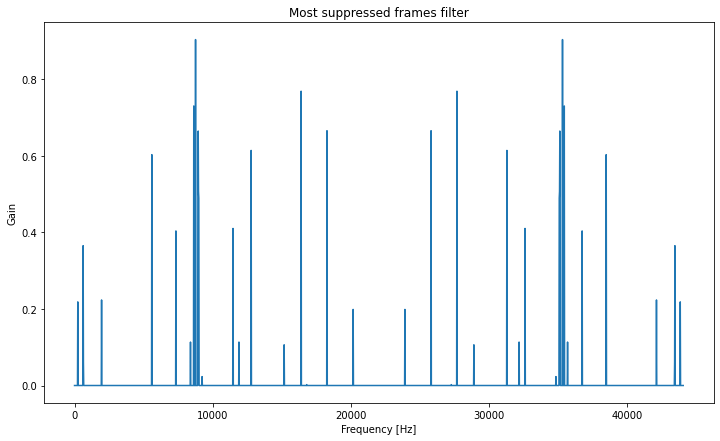

In [10]:
precision = np.finfo(np.float32).eps

print('WIENER FILTER CASE')
print('')

## Parameters
# These are the parameters to tune in order to have a desired type of suppresion
a = 1
b = 1
c = 1

## Rule

outWF = suppressionRule(n_frames, n_frames_noise, precision, a, b, c, hopsize, winlen, win, nfft, P_v)
#

print('POWER SPECTRAL MATCHING CASE')
print('')

a = 1
b = 1/2
c = 1

## Rule

outPSM = suppressionRule(n_frames, n_frames_noise, precision, a, b, c, hopsize, winlen, win, nfft, P_v)
#

print('SPECTRAL MATCHING CASE')
print('')

a = 1
b = 1
c = 1/2

## Rule

outSM = suppressionRule(n_frames, n_frames_noise, precision, a, b, c, hopsize, winlen, win, nfft, P_v)
#

print('SPECTRAL MATCHING WITH NOISE FLOOR CASE')
print('')

a = 1/2
b = 1
c = 1/2

## Rule

outSM_noMN = suppressionRule(n_frames, n_frames_noise, precision, a, b, c, hopsize, winlen, win, nfft, P_v)
#

print('WIENER FILTER WITH NOISE SOVRAESTIMATION CASE')
print('')

a = 9/2
b = 1
c = 1

## Rule

outWF_noMN = suppressionRule(n_frames, n_frames_noise, precision, a, b, c, hopsize, winlen, win, nfft, P_v)


## Final Results

WIENER FILTER CASE

SNR in = 23.226612361877063
SNR out = 17.30028246520738
WAV file:  Fs = 44100, x.shape = (486935,), x.dtype = float64


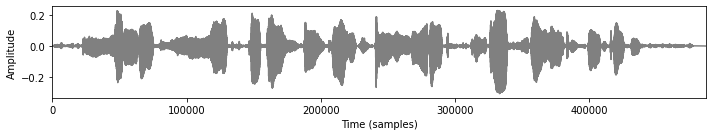

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


POWER SPECTRAL MATCHING CASE

SNR in = 23.226612361877063
SNR out = 8.282803250972202
WAV file:  Fs = 44100, x.shape = (486935,), x.dtype = float64


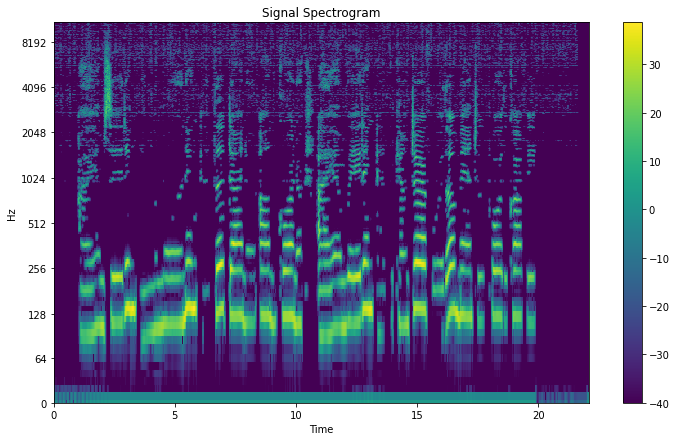

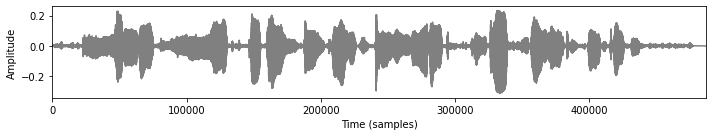

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


SPECTRAL MATCHING CASE

SNR in = 23.226612361877063
SNR out = -31.793809575787407
WAV file:  Fs = 44100, x.shape = (486935,), x.dtype = float64


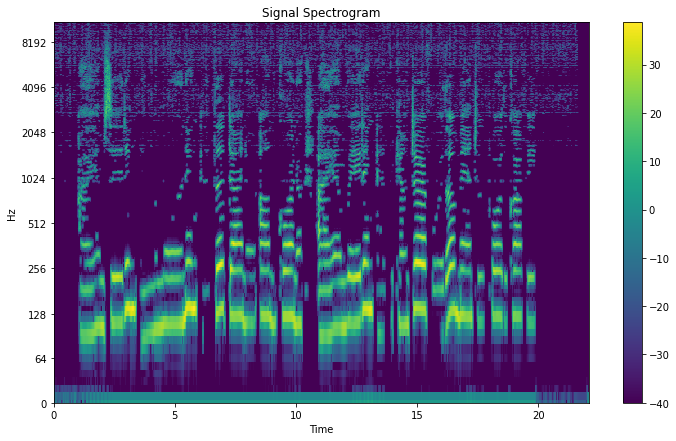

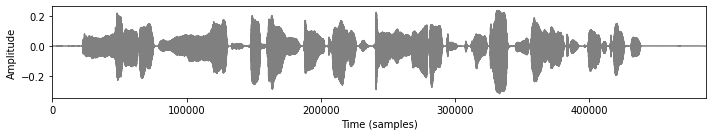

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


SPECTRAL MATCHING WITH NOISE FLOOR CASE

SNR in = 23.226612361877063
SNR out = -18.46208731119766
WAV file:  Fs = 44100, x.shape = (486935,), x.dtype = float64


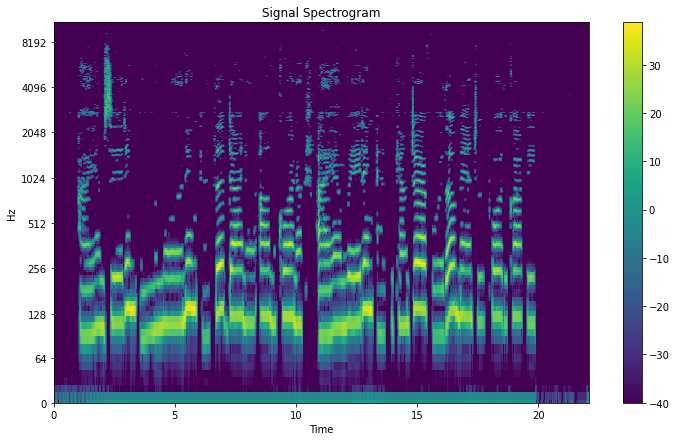

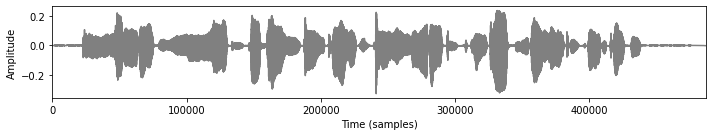

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


WIENER FILTER WITH NOISE SOVRAESTIMATION CASE

SNR in = 23.226612361877063
SNR out = 2.90534864408208
WAV file:  Fs = 44100, x.shape = (486935,), x.dtype = float64


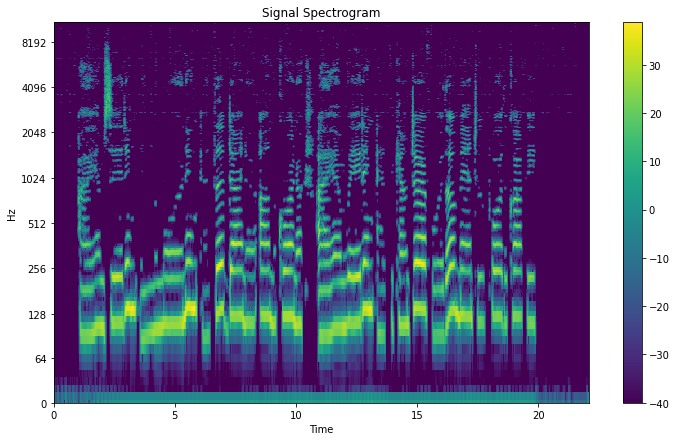

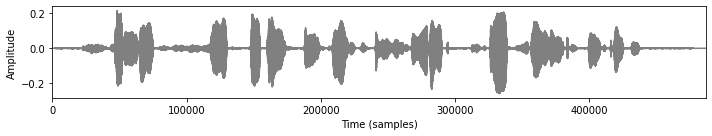

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


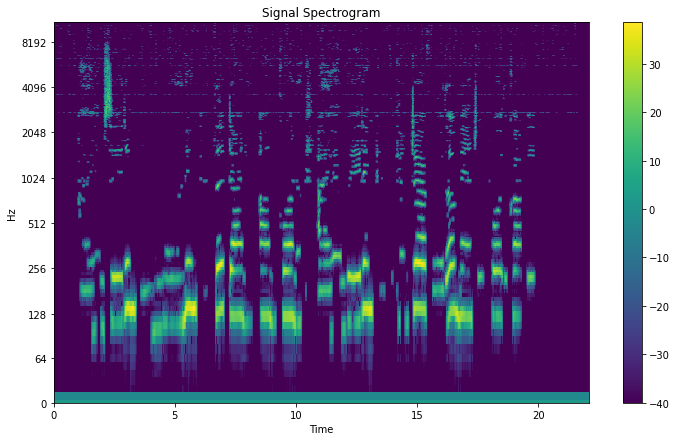

In [11]:
print('WIENER FILTER CASE')
print('')
printAndPlotResults(outWF, sig, nfft, noise_frame, hopsize_noise, only_noise_samples, r_v, precision, mean_sig, mean_noise, hopsize)
print('POWER SPECTRAL MATCHING CASE')
print('')
printAndPlotResults(outPSM, sig, nfft, noise_frame, hopsize_noise, only_noise_samples, r_v, precision, mean_sig, mean_noise, hopsize)
print('SPECTRAL MATCHING CASE')
print('')
printAndPlotResults(outSM, sig, nfft, noise_frame, hopsize_noise, only_noise_samples, r_v, precision, mean_sig, mean_noise, hopsize)
print('SPECTRAL MATCHING WITH NOISE FLOOR CASE')
print('')
printAndPlotResults(outSM_noMN, sig, nfft, noise_frame, hopsize_noise, only_noise_samples, r_v, precision, mean_sig, mean_noise, hopsize)
print('WIENER FILTER WITH NOISE SOVRAESTIMATION CASE')
print('')
printAndPlotResults(outWF_noMN, sig, nfft, noise_frame, hopsize_noise, only_noise_samples, r_v, precision, mean_sig, mean_noise, hopsize)